In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
! pip install xrft --upgrade -q

# Dask start

In [5]:
from dask.distributed import Client, progress

In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34153")
client

<Client: 'tcp://127.0.0.1:34153' processes=4 threads=8, memory=29.40 GiB>

# Import

In [51]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gcm_filters
import gsw
from xhistogram.xarray import histogram
import eos_module
from dask import compute
import xrft
from dask.diagnostics import ProgressBar
from dask import delayed

# Load data

Load Pangeo catalog

In [11]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

Winter data:

In [12]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma').to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})

Summer data:

In [13]:
enatl01s = cat.eNATL60(region='1',datatype='surface_hourly', season='aso').to_dask().chunk({'time_counter':1, 'x' : -1, 'y' : -1})

# Prepare data for filter

## Slicing

In [14]:
enatl01s.time_counter.size

2208

In [15]:
x_slice = slice(400,700)
y_slice = slice(500,800)

In [16]:
# x_slice = slice(0,-1)
# y_slice = slice(0,-1)

In [17]:
data_slice = dict(time_counter=slice(0,-1),y=y_slice,x=x_slice)

In [18]:
coord_slice = dict(y=y_slice,x=x_slice)

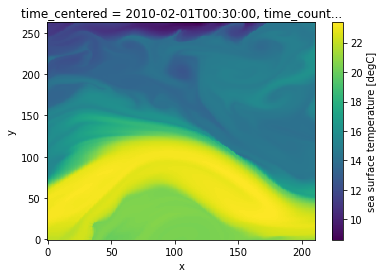

In [19]:
enatl01w.isel(time_counter=0).sosstsst[coord_slice].plot()

## Grid

In [20]:
area = xr.DataArray((enatl01w.e1t[coord_slice] * enatl01w.e2t[coord_slice]), dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load()
# area.plot()

Spacings:

In [21]:
dxw = xr.DataArray(enatl01w.e1u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v[coord_slice], dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
                  ).load() # y-spacing centered at southern cell edge

In [22]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(1316.89602344)

Diffusivities for thefilter in the east-west and north-south directions

In [23]:
kappa_w = xr.ones_like(dxw)
kappa_s = xr.ones_like(dxw)

## Mask

In [24]:
wet_mask = xr.DataArray(enatl01w.umask[coord_slice],
                        dims=['y','x'],
                        coords={'y':np.arange(len(enatl01w.y[y_slice])),
                           'x':np.arange(len(enatl01w.x[x_slice]))}
           ).load()

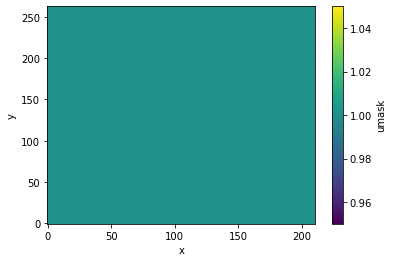

In [25]:
wet_mask.plot()

## High-resolution dataset

In [26]:
dataHR = xr.Dataset({"sst" : enatl01s.sosstsst[data_slice],
                     "sal" : enatl01s.sosaline[data_slice],
                     "wet_mask" : wet_mask},
                    coords=enatl01s[data_slice].coords)

# Filter

## Define filter

Parameters (to determine) :

In [27]:
filter_scale = 30000

In [28]:
gaussian_filter = gcm_filters.Filter(
    filter_scale=filter_scale,    
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask, 
        'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
        'kappa_w': kappa_w, 'kappa_s': kappa_s
    }
)

In [29]:
# gaussian_filter = gcm_filters.Filter(
#     filter_scale=6,   # 12 grid cells
#     dx_min=1,
#     filter_shape=gcm_filters.FilterShape.GAUSSIAN,
#     grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
#     grid_vars={
#         'wet_mask': wet_mask
#     }
# )

## Apply filter to data

In [30]:
# intermediate dataset: HR data + filtering (result has still the spatial resoltion if HR data)
data_filtered = xr.Dataset({}, coords=enatl01s[data_slice].coords)

"Lazy" filter execution with Dask

In [31]:
data_filtered["sst"] = gaussian_filter.apply(dataHR.sst, dims=['y', 'x'])
data_filtered["sal"] = gaussian_filter.apply(dataHR.sal, dims=['y', 'x'])

# Spatial coarsening (downsampling)

In [32]:
coarsen_window_size=12

In [33]:
# def downsample(data, window_size) :
#     return data.coarsen(x=window_size, boundary='pad').mean().coarsen(y=window_size,boundary='pad').mean()*
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsen_window_size, y=coarsen_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean',
                                                      'e1t' : 'sum', 'e2t' : 'sum'}).sum(skipna=False)
    area_window_sums = area_masked.coarsen(x=coarsen_window_size, y=coarsen_window_size, boundary='trim').sum(skipna=False)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    return result

In [34]:
dataLR = downsample(data_filtered, coarsen_window_size, area, wet_mask)

In [35]:
it = [1]

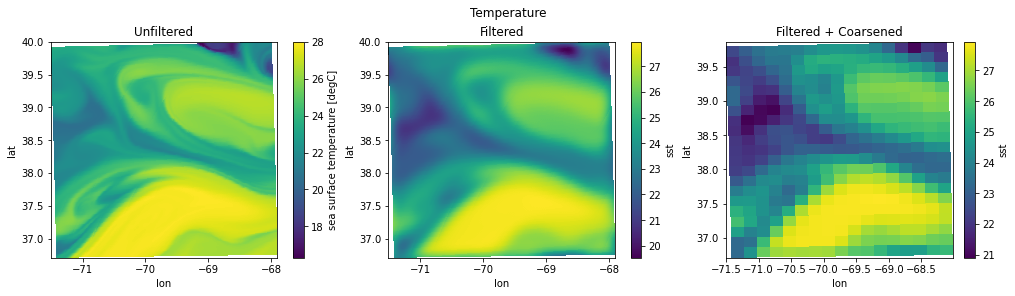

In [36]:
fig, ax = plt.subplots(ncols=3, constrained_layout=True, figsize=(14,4))
fig.suptitle('Temperature')
(dataHR.isel(time_counter=it)).sst.plot(ax=ax[0],x='lon', y='lat')
ax[0].set(title=r'Unfiltered')
(data_filtered.isel(time_counter=it)).sst.plot(ax=ax[1],x='lon', y='lat')
#ax[1].pcolormesh(dataset_filtered.lon, dataset_filtered.lat, dataset_filtered.sst.compute())
ax[1].set(title=r'Filtered')
(dataLR.isel(time_counter=it)).sst.plot(ax=ax[2], x='lon', y='lat')
ax[2].set(title=r'Filtered + Coarsened')
plt.show()

# Spatial spectra

## Interpolation on a spatially uniform grid 

In [37]:
def uniform_grid_interpolation(data) :
    delta_x_min_m = data['e1t'].min().values
    delta_y_min_m = data['e2t'].min().values
    delta_min = np.min([delta_x_min_m, delta_y_min_m])
    new_x = np.cumsum(delta_min/data['e1t'], axis=1)
    new_y = np.cumsum(delta_min/data['e2t'], axis=0)
    interpolated_field = data.interp(x=new_x, y=new_y).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    interpolated_field.attrs['delta_min'] = delta_min
    return interpolated_field

In [38]:
interpolatedHR = uniform_grid_interpolation(dataHR)

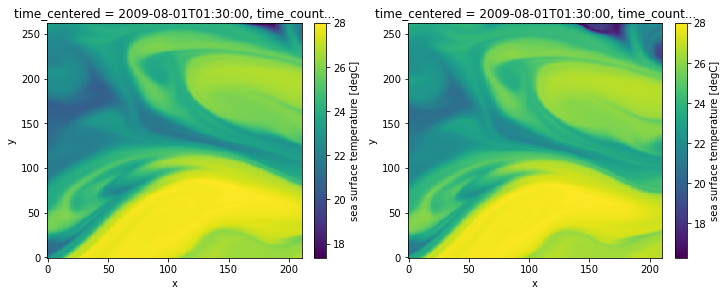

In [39]:
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
(interpolatedHR.isel(time_counter=it)).sst.plot(ax=ax[0])
(dataHR.isel(time_counter=it)).sst.plot(ax=ax[1])
plt.show()

## Isotropic power spectra

In [80]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor) :
    interpolated_data = uniform_grid_interpolation(data[variable]).fillna(0.)
    isotropic_PS = xrft.isotropic_power_spectrum(interpolated_data, dim=['x','y'], shift=True, detrend='constant', truncate=True, \
                                                    nfactor=binning_factor)
    N = len(data['x'])
    delta_x = interpolated_data.attrs['delta_min']*0.001
    isotropic_PS['wavenumbers'] = ("freq_r", np.arange(1,len(isotropic_PS['freq_r'])+1)/(N*delta_x))
    return isotropic_PS

In [103]:
spec_temp_variance_HR = wrapper_xrtf_isotropic_PS(dataHR, 'sst', 4)
mean_spec_temp_variance_HR = spec_temp_variance_HR.mean(dim='time_counter').compute()

In [104]:
spec_temp_variance_filtered = wrapper_xrtf_isotropic_PS(data_filtered, 'sst', 4)
mean_spec_temp_variance_filtered = spec_temp_variance_filtered.mean(dim='time_counter').compute()

In [105]:
spec_temp_variance_LR = wrapper_xrtf_isotropic_PS(dataLR, 'sst', 1)
mean_spec_temp_variance_LR = spec_temp_variance_LR.mean(dim='time_counter').compute()

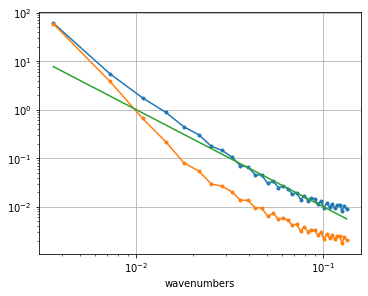

In [106]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
mean_spec_temp_variance_HR.plot(x='wavenumbers', ax=ax, ls='-', marker='.', label='HR')
mean_spec_temp_variance_filtered.plot(x='wavenumbers', ax=ax, ls='-', marker='.', label='Filtered')
#mean_spec_temp_variance_LR.plot(x='wavenumbers', ax=ax, ls='-', marker='.', label='LR')
ax.plot(spec_temp_variance_HR['wavenumbers'], 1e-4*spec_temp_variance_HR['wavenumbers']**(-2))
ax.set(yscale='log', xscale='log')
ax.grid(True)
plt.show()